# This is the Building of Models for the kaggle Housing Competition

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from utils import *


plt.style.use('deeplearning.mplstyle')

In [11]:
# Loading, Cleaning and One Hot Encoding Data

data = './data/train.csv'
df = modifying_data(data)

data before processing...
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePri

In [8]:
# Splitting Data into train and cross validation set
X = df.drop('SalePrice', axis=1)
Y = df['SalePrice']
print(len(X))

X = X.values
Y = Y.values

X_train, X_cv, Y_train, Y_cv = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_cv shape: {X_cv.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_cv shape: {Y_cv.shape}')


1460
X_train shape: (1168, 22)
X_cv shape: (292, 22)
Y_train shape: (1168,)
Y_cv shape: (292,)


In [9]:
# viewing the split data set

print(f'The first two training input: {X_train[:2]}')
print(f'The first two cross validation input: {X_cv[:2]}')
print(f'The first five training target: {Y_train[:5]}')
print(f'The first five cross validation target: {Y_cv[:5]}')

The first two training input: [[7.000e+01 8.400e+03 5.000e+00 6.000e+00 1.957e+03 0.000e+00 9.220e+02
  3.920e+02 1.314e+03 1.314e+03 0.000e+00 1.314e+03 1.000e+00 0.000e+00
  1.000e+00 0.000e+00 3.000e+00 1.000e+00 5.000e+00 0.000e+00 1.000e+00
  0.000e+00]
 [5.900e+01 7.837e+03 6.000e+00 7.000e+00 1.993e+03 0.000e+00 0.000e+00
  7.990e+02 7.990e+02 7.990e+02 7.720e+02 1.571e+03 0.000e+00 0.000e+00
  2.000e+00 1.000e+00 3.000e+00 1.000e+00 7.000e+00 1.000e+00 2.000e+00
  0.000e+00]]
The first two cross validation input: [[7.0000e+01 8.4140e+03 6.0000e+00 8.0000e+00 1.9630e+03 0.0000e+00
  6.6300e+02 3.9600e+02 1.0590e+03 1.0680e+03 0.0000e+00 1.0680e+03
  0.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00 3.0000e+00 1.0000e+00
  6.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00]
 [9.8000e+01 1.2256e+04 8.0000e+00 5.0000e+00 1.9940e+03 3.6200e+02
  1.0320e+03 4.3100e+02 1.4630e+03 1.5000e+03 1.1220e+03 2.6220e+03
  1.0000e+00 0.0000e+00 2.0000e+00 1.0000e+00 3.0000e+00 1.0000e+00
  9.0000e+00 2.000

Linear Regression Model 

Training Model with 1 degree polynomial
Predictions for degree 1: [137058.76828771 189319.66027516  67390.59292446 168498.92057763
 131949.50296506]
Training Model with 2 degree polynomial
Predictions for degree 2: [143587.47562301 174042.36856614  84896.66430489 156817.40965018
 136845.96029415]
Training Model with 3 degree polynomial
Predictions for degree 3: [144999.99999996 178000.00000001  84999.99999999 174999.99999995
 126999.99999996]
Training Model with 4 degree polynomial
Predictions for degree 4: [145000.00147341 178000.02891634  85000.0045719  175000.00981043
 127000.03766249]
Target: [145000 178000  85000 175000 127000]
Degree: 1, Train MSE: 611775199.4347619, Train RMSE: 24734.08982426404
Degree: 1, CV MSE: 674883530.6252548, CV RMSE: 25978.520562673595
Degree: 2, Train MSE: 175541266.12548795, Train RMSE: 13249.198697486876
Degree: 2, CV MSE: 728284465.36983, CV RMSE: 26986.74610563174
Degree: 3, Train MSE: 24782.770547945205, Train RMSE: 157.42544441082327
Degree: 3, CV

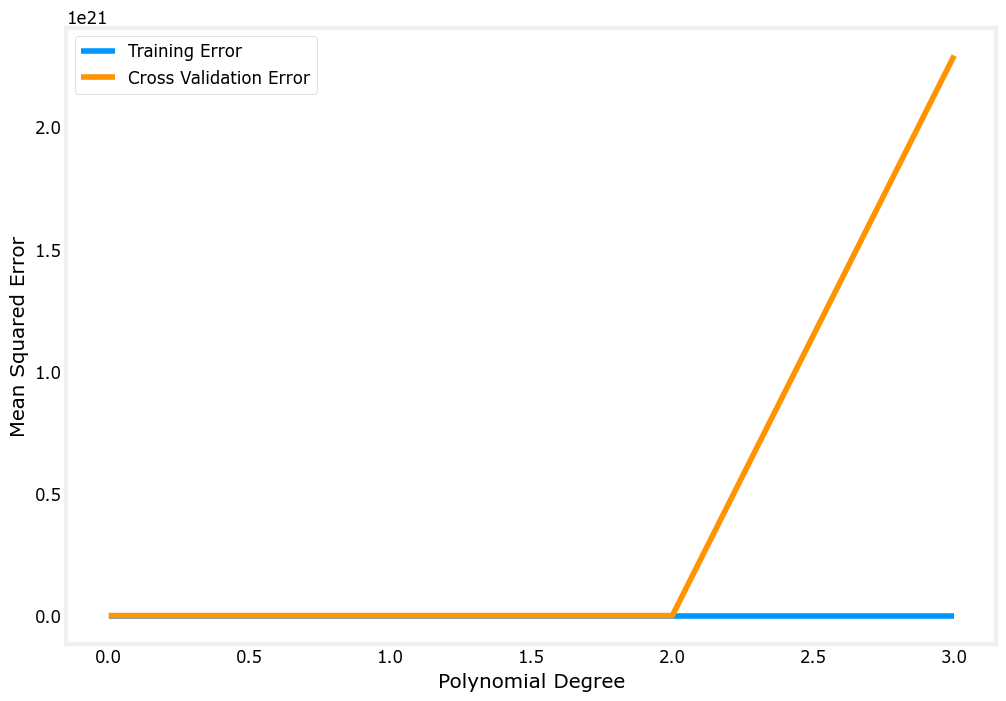

In [6]:
# Building a linear regression model
train_mse = []
cv_mse = []
polys = []
models = []
scalers = []

for i in range(1, 5):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_cv_poly = poly.transform(X_cv)
    polys.append(poly)


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_cv_scaled = scaler.transform(X_cv_poly)
    scalers.append(scaler)
    
    print(f'Training Model with {i} degree polynomial')
    model = LinearRegression()
    model.fit(X_train_scaled, Y_train)
    models.append(model)
    
    yhat = model.predict(X_train_scaled)
    error = mean_squared_error(Y_train, yhat) / 2
    train_mse.append(error)
    
    yhat_cv = model.predict(X_cv_scaled)
    error_cv = mean_squared_error(Y_cv, yhat_cv) / 2
    cv_mse.append(error_cv)
    print(f'Predictions for degree {i}: {yhat[:5]}')
# Printing the prediction and the target value
print(f'Target: {Y_train[:5]}')
# printing results
for i in range(len(train_mse)):
    print(f'Degree: {i + 1}, Train MSE: {train_mse[i]}, Train RMSE: {np.sqrt(train_mse[i])}')
    print(f'Degree: {i + 1}, CV MSE: {cv_mse[i]}, CV RMSE: {np.sqrt(cv_mse[i])}')
    
# Plotting the training and cross validation error
plt.plot(train_mse, label='Training Error')
plt.plot(cv_mse, label='Cross Validation Error')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [7]:
# Selecting the best model based on the cross validation set
degree = np.argmin(cv_mse) + 1
print(f'Best Model is with degree : {degree}')

Best Model is with degree : 1


In [8]:
# checking to see the scaler input 
new_scaler = scalers[degree - 1]
print(scaler.n_features_in_)

14949


In [9]:
# Preprocessing the test data
test_data = './data/test.csv'
df_test = modifying_data(test_data)

test_data = df_test.values
test_data = polys[degree - 1].transform(test_data)
scaler = scalers[degree - 1]
X_test_scaled = scaler.transform(X)
print(f'Test input after scaling: {X_test_scaled[:2]}')


data before processing...
     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCo

In [10]:
# Using the best model to predict the test data
yhat_test = models[degree - 1].predict(X_test_scaled)
print(yhat_test[:10])
print(len(yhat_test))

[228165.26016326 185219.06353252 222441.39301355 197084.34974034
 288848.70471463 167358.57587426 264046.84182373 247564.63514617
 177391.38480716 107316.65009545]
1460


Building a Neural Network model

In [15]:
# Using tensorflow to build a model

def build_nn_model():
    tf.random.set_seed(42)

    model1 = Sequential(
        [
            Dense(120, activation='relu'),
            Dense(60, activation='relu'),
            Dense(30, activation='relu'),
            Dense(1, activation='relu')
        ],
        name='model1'
    )

    model2 = Sequential(
        [
            Dense(200, activation='relu'),
            Dense(150, activation='relu'),
            Dense(120, activation='relu'),
            Dense(100, activation='relu'),
            Dense(75, activation='relu'),
            Dense(50, activation='relu'),
            Dense(25, activation='relu'),
            Dense(1, activation='relu')
        ],
        name='model2'
    )

    model3 = Sequential(
        [
            Dense(50, activation='relu'),
            Dense(25, activation='relu'),
            Dense(1, activation='relu')
        ],
        name='model3'
    )

    model4 = Sequential(
        [
            Dense(300, activation='relu'),
            Dense(250, activation='relu'),
            Dense(200, activation='relu'),
            Dense(150, activation='relu'),
            Dense(100, activation='relu'),
            Dense(50, activation='relu'),
            Dense(25, activation='relu'),
            Dense(1, activation='relu')
        ],
        name='model4'
    )

    models_nn = [model1, model2, model3, model4]
    return models_nn

In [16]:
# Scaling the data for the neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
print(f'X_train_scaled: {X_train_scaled[:2]}')
print(f'X_cv_scaled: {X_cv_scaled[:2]}')

X_train_scaled: [[-0.00419319 -0.21289571 -0.82044456  0.3722173  -0.45546896 -0.5978887
   1.03726861 -0.40028165  0.57261219  0.37423523 -0.80192292 -0.40709315
   1.10531958 -0.24287002 -1.05556573 -0.76409752  0.13621832 -0.21275711
  -0.96456591 -0.95859215 -1.05654384 -0.07099284]
 [-0.49395768 -0.26524463 -0.08893368  1.26860866  0.71860895 -0.5978887
  -0.97199573  0.51191969 -0.59654659 -0.95820221  0.9550877   0.08317013
  -0.81869424 -0.24287002  0.7736639   1.23694711  0.13621832 -0.21275711
   0.27075534  0.59214972  0.29509165 -0.07099284]]
X_cv_scaled: [[-0.00419319 -0.21159396 -0.08893368  2.16500001 -0.25978931 -0.5978887
   0.47284403 -0.39131652 -0.00629167 -0.26223003 -0.80192292 -0.87637239
  -0.81869424  3.99104322 -1.05556573 -0.76409752  0.13621832 -0.21275711
  -0.34690528 -0.95859215 -1.05654384 -0.07099284]
 [ 1.24248005  0.14564323  1.37408806 -0.52417405  0.75122223  1.49856692
   1.27698562 -0.31287169  0.91087367  0.85546506  1.75165987  2.08809894
   1.1

In [17]:
# Training the models
train_mse = []
cv_mse = []

models = build_nn_model()
for model in models:
    scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=15, verbose=1)
    # compiling the loss on model
    model.compile(
        loss= tf.keras.losses.MeanSquaredError(),
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    )
    
    print(f'Training Model: {model.name}')
    model.fit(X_train_scaled, np.log(Y_train), epochs= 300, verbose= 1, callbacks=[scheduler])
    
    print(f'Done Training: {model.name}')
    
    # Calculating mses for training set
    
    yhat = model.predict(X_train_scaled)
    yhat = np.exp(yhat)
    error = mean_squared_error(Y_train, yhat) / 2
    train_mse.append(error)
    
    #  Calculating mse for cross validation set
    
    yhat_cv = model.predict(X_cv_scaled)
    yhat_cv = np.exp(yhat_cv)
    error_cv = mean_squared_error(Y_cv, yhat_cv) / 2
    cv_mse.append(error_cv)
    print(yhat[:5])

print(Y_train[:5])
print('Done')
print('Results:')
for i in range(len(models)):
    print(f'{models[i].name}: Training_mse: {train_mse[i]}, RMSE: {np.sqrt(train_mse[i])}')  
    print(f'{models[i].name}: CV_mse: {cv_mse[i]}, RMSE: {np.sqrt(cv_mse[i])}')

Training Model: model1
Epoch 1/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 41.8688 - learning_rate: 0.0100
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4556 - learning_rate: 0.0100
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2465 - learning_rate: 0.0100
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7796 - learning_rate: 0.0100
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5336 - learning_rate: 0.0100
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4658 - learning_rate: 0.0100
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3996 - learning_rate: 0.0100
Epoch 8/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3420 - learning_rate: 0.0100
Epoch 9/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3098 - learning_rate: 0.0100
Epoch 10/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2427 - learning_rate: 0.0100
Epoch 11/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2250 - learni

In [18]:
# Selecting the best model
best_model = np.argmin(cv_mse)
print(f'Best Model is: {models[best_model].name}')

Best Model is: model4


In [19]:
# Preprocessing the test data
test_data = './data/test.csv'
df_test = modifying_data(test_data)
df_test = df_test.values
X_test_scaled = scaler.transform(df_test)
print(f'Test input after scaling: {X_test_scaled[:2]}')

data before processing...
     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCo

In [20]:
# Using the best model to predict the test data
yhat_test = models[best_model].predict(X_test_scaled)
yhat_test = np.exp(yhat_test)
print(yhat_test[:10])

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[122207.44]
 [155767.9 ]
 [176666.12]
 [195381.19]
 [180129.61]
 [179573.02]
 [194673.5 ]
 [160311.44]
 [211206.28]
 [124288.53]]


Selecting the neural network for the submission 

In [25]:
# Selecting the neural network cause of its lover CV mse
# Adding the prediction to the submission file
df_sub = pd.read_csv('./data/sample_submission.csv')
yhat_test = yhat_test.flatten()

new_submission = pd.DataFrame({'Id': df_sub['Id'], 'SalePrice': yhat_test})
new_submission.to_csv('./data/submission.csv', index=False)
print(len(yhat_test))
print(len(df_sub))

1459
1459
